In [1]:
import pandas as pd
import mysql.connector
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

import numpy as np
import seaborn as sns                       
import matplotlib.pyplot as plt             
%matplotlib inline     
sns.set(color_codes=True)

import os
import scipy as sp
import warnings
import datetime
warnings.filterwarnings("ignore")
%matplotlib inline


# Menghubungkan ke database MySQL
db_connection = mysql.connector.connect(
    host="localhost",  # Ganti dengan host database Anda
    user="root",   # Ganti dengan username database Anda
    password="",  # Ganti dengan password database Anda
    database="jurujual_pos"  # Ganti dengan nama database Anda
)

# Memuat data dari tabel
query = """
SELECT s.date AS Tanggal, s.reference AS Reference, s.customer_name AS Pembeli, 
    p.product_unit AS Satuan, p.product_name AS Produk, c.category_name AS Kategori,
    sd.quantity AS Qty, p.product_price AS HargaJual, sd.product_discount_amount AS Diskon,
    sp.amount AS SubTotal, s.payment_method AS MetodePembayaran, 
    s.status AS Status, s.payment_status AS StatusPembayaran
    
FROM sales s
JOIN sale_details sd ON s.id = sd.sale_id
JOIN sale_payments sp ON s.id = sp.sale_id
JOIN products p ON sd.product_id = p.id
JOIN categories c ON p.category_id = c.id;
"""

df = pd.read_sql(query, con=db_connection)
db_connection.close()

In [2]:
# Menampilkan data dengan DataFrame
print("Jumlah baris data:", len(df))
print("\nTampilan 5 baris pertama:")
print(df.head())

Jumlah baris data: 41370

Tampilan 5 baris pertama:
      Tanggal Reference Pembeli Satuan                Produk  \
0  2023-01-27  SL-00262   60015    Bks  INACO MINI JELLY 15s   
1  2023-03-31  SL-05848   P0331    Bks  INACO MINI JELLY 15s   
2  2023-03-30  SL-06027   P0331    Bks  INACO MINI JELLY 15s   
3  2023-03-15  SL-07675   P0331    Bks  INACO MINI JELLY 15s   
4  2023-03-10  SL-09708   P0331    Bks  INACO MINI JELLY 15s   

           Kategori  Qty  HargaJual  Diskon  SubTotal MetodePembayaran  \
0   AGAR AGAR/JELLY    1     700000       0    700000      Potong Gaji   
1   AGAR AGAR/JELLY    1     700000       0    700000            Tunai   
2   AGAR AGAR/JELLY    2     700000       0   1400000            Tunai   
3   AGAR AGAR/JELLY    1     700000       0    700000            Tunai   
4   AGAR AGAR/JELLY    1     700000       0    700000            Tunai   

      Status StatusPembayaran  
0  Completed             Paid  
1  Completed             Paid  
2  Completed          

In [3]:
# Menampilkan info data
print("\nInformasi data:")
df.info()


Informasi data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41370 entries, 0 to 41369
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Tanggal           41370 non-null  object
 1   Reference         41370 non-null  object
 2   Pembeli           41370 non-null  object
 3   Satuan            41370 non-null  object
 4   Produk            41370 non-null  object
 5   Kategori          41370 non-null  object
 6   Qty               41370 non-null  int64 
 7   HargaJual         41370 non-null  int64 
 8   Diskon            41370 non-null  int64 
 9   SubTotal          41370 non-null  int64 
 10  MetodePembayaran  41370 non-null  object
 11  Status            41370 non-null  object
 12  StatusPembayaran  41370 non-null  object
dtypes: int64(4), object(9)
memory usage: 4.1+ MB


In [4]:
duplicate_rows_df = df[df.duplicated()]
print("jumlah baris duplikat: ", duplicate_rows_df.shape)

jumlah baris duplikat:  (0, 13)


In [5]:
df.duplicated().any()

False

In [6]:
df.count()      # Digunakan untuk menghitung jumlah baris

Tanggal             41370
Reference           41370
Pembeli             41370
Satuan              41370
Produk              41370
Kategori            41370
Qty                 41370
HargaJual           41370
Diskon              41370
SubTotal            41370
MetodePembayaran    41370
Status              41370
StatusPembayaran    41370
dtype: int64

In [7]:
print(df.isnull().sum())

Tanggal             0
Reference           0
Pembeli             0
Satuan              0
Produk              0
Kategori            0
Qty                 0
HargaJual           0
Diskon              0
SubTotal            0
MetodePembayaran    0
Status              0
StatusPembayaran    0
dtype: int64


In [8]:
df.isna().sum() / df.shape[0]

Tanggal             0.0
Reference           0.0
Pembeli             0.0
Satuan              0.0
Produk              0.0
Kategori            0.0
Qty                 0.0
HargaJual           0.0
Diskon              0.0
SubTotal            0.0
MetodePembayaran    0.0
Status              0.0
StatusPembayaran    0.0
dtype: float64

In [9]:
df.describe() # Melihat info dari nilai numerik

,Qty,HargaJual,Diskon,SubTotal
count,41370.000000,4.137000e+04,41370.0,4.137000e+04
mean,2.434373,1.613611e+06,0.0,2.539086e+06
std,6.938579,3.009010e+06,0.0,7.225199e+06
min,1.000000,3.000000e+04,0.0,2.000000e+02
25%,1.000000,4.500000e+05,0.0,8.000000e+05
50%,1.000000,1.100000e+06,0.0,1.500000e+06
75%,2.000000,1.950000e+06,0.0,2.650000e+06
max,600.000000,1.260000e+08,0.0,5.822500e+08


In [10]:
df.describe(include = object) # Melihat info dari nilai kategori 

,Tanggal,Reference,Pembeli,Satuan,Produk,Kategori,MetodePembayaran,Status,StatusPembayaran
count,41370,41370,41370,41370,41370,41370,41370,41370,41370
unique,232,41370,361,19,3724,78,3,1,1
top,2023-03-09,SL-00262,P0331,Bks,GULA PASIR LOKAL 1 KG,ROKOK,Tunai,Completed,Paid
freq,1635,1,11152,17419,636,4769,21241,41370,41370


In [11]:
pd.options.display.max_rows = None
df['Pembeli'].value_counts()

P0331    11152
60029      781
90002      754
60222      743
P0332      661
P0330      660
10062      646
10071      613
90001      563
60247      542
50013      533
60209      499
60049      476
50027      470
60236      442
50009      435
30050      434
10038      430
60176      428
60253      416
60257      412
60133      409
60139      407
90003      405
20027      383
40016      378
60221      355
60042      320
60074      313
90005      304
30094      304
60320      303
50054      298
60192      295
60173      292
20056      291
90004      268
30080      251
60144      244
60301      225
60315      221
60313      219
30016      212
60283      205
10048      201
10042      201
60169      197
50037      193
30002      190
60251      189
60190      189
60113      182
40063      181
10031      174
60105      171
60241      169
Umum       166
60202      152
50035      150
50039      148
30096      147
10076      145
20064      145
60108      145
60091      142
50062      140
60309     

In [12]:
df['Tanggal'].value_counts()

2023-03-09    1635
2023-03-10    1051
2023-03-14     628
2023-03-13     467
2023-04-04     395
2023-04-05     364
2023-10-03     352
2023-03-17     302
2023-10-10     291
2023-02-17     282
2023-10-09     279
2023-03-16     278
2023-01-09     275
2023-11-01     271
2023-12-19     268
2023-12-22     266
2023-10-24     261
2023-03-15     260
2023-09-13     257
2023-07-10     256
2023-08-08     253
2023-12-15     251
2023-07-07     248
2023-09-29     245
2023-09-18     243
2023-06-06     242
2023-12-04     237
2023-08-04     235
2023-06-08     230
2023-12-11     229
2023-04-17     227
2023-11-06     227
2023-10-16     226
2023-11-10     226
2023-12-18     225
2023-04-06     225
2023-02-07     223
2023-10-23     223
2023-09-01     220
2023-09-06     220
2023-03-21     219
2023-11-21     219
2023-12-20     219
2023-04-10     218
2023-12-06     218
2023-12-08     216
2023-11-27     215
2023-03-24     214
2023-02-08     213
2023-09-05     213
2023-07-04     213
2023-11-08     211
2023-01-02  

In [13]:
df['Satuan'].value_counts()

Bks         17419
PCS         11837
Botol        4529
Unit         1962
Kotak        1687
Sachet       1149
Biji          924
Kaleng        668
Buah          303
unit          294
Lembar        167
Gram          126
Kilogram       85
Roll           76
Box            64
Helai          56
UNIT           10
Gross           9
Rim             5
Name: Satuan, dtype: int64

In [14]:
df['Produk'].value_counts()

GULA PASIR LOKAL 1 KG                                                  636
GUDANG GARAM FILTER INTERNATIONAL 12s                                  450
INDOMIE GORENG SPECIAL 85 GR                                           365
SAMPOERNA A MILD MERAH 16s                                             325
KOPI KAPAL API SPECIAL 165 GR                                          310
GUDANG GARAM SURYA 16s                                                 266
BERAS DELANGGU C4 5 KG                                                 240
MARLBORO CRAFTED SELECTION 12s                                         221
ADES AIR MINERAL BOTOL 600 ML                                          210
BERAS DELANGGU MENTIK 5 KG                                             204
SUPER SNACK KRIPIK TEMPE                                               204
GUDANG GARAM SIGNATURE HITAM 12s                                       202
DJI SAM SOE SUPER PREMIUM KRETEK 12s                                   185
INDOMIE REBUS AYAM BAWANG

In [15]:
df['Kategori'].value_counts()

 ROKOK                             4769
 SNACK/MAKANAN RINGAN              3804
 KONSINYASI                        3151
 MINUMAN /SOFTDRINK                3100
 MIE INSTANT/KERING                2334
 SABUN MANDI                       1711
 KOPI                              1619
 SUSU                              1528
 GULA PASIR/JAWA                   1237
 DETERGEN                           910
 PASTA GIGI                         874
 MINYAK GORENG                      854
 TEH CELUP/SEDUH                    839
 TISSUE KERING/BASAH                818
 OBAT/SUPLEMENT                     799
 BERAS                              754
 SHAMPOO & HAIR BEAUTY              617
 SABUN CUCI PIRING/TANGAN/BOTOL     579
 MINUMAN SERBUK                     565
 COKLAT                             537
 KAMPER/KAPUR BARUS                 524
 PEWANGI/PEMUTIH PAKAIAN            473
 MINYAK KP/TELON/ANGIN/GOSOK        463
 KECAP                              428
 BUMBU DAPUR MENTAH/INSTANT         423


In [16]:
df['MetodePembayaran'].value_counts()

Tunai          21241
Potong Gaji    12254
Kredit          7875
Name: MetodePembayaran, dtype: int64

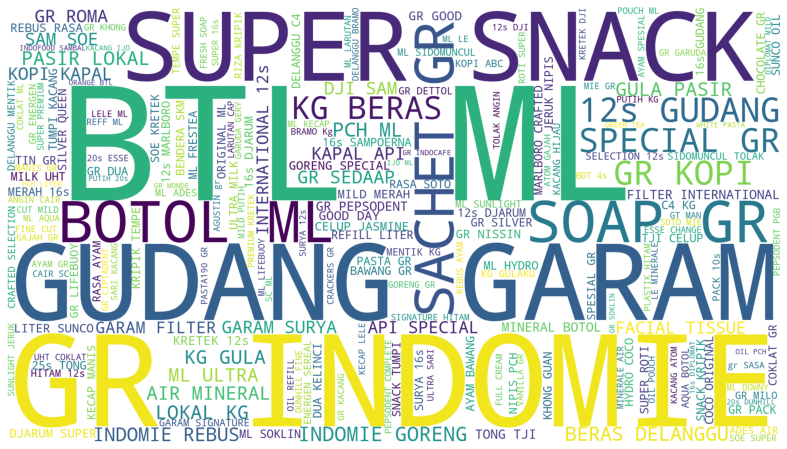

In [17]:
from wordcloud import WordCloud
plt.subplots(figsize=(20,8))
wordcloud = WordCloud(background_color='White',width=1920,height=1080).generate(" ".join(df['Produk']))
plt.imshow(wordcloud)
plt.axis('off')
#plt.savefig('cast.png')
plt.show()

In [18]:
def count_plot(x_axis, hue = None, rotation = 0):
    print(f"x_axis: {x_axis}")
    print(f"df.columns: {df.columns}")
    print(f"df[x_axis].dtype: {df[x_axis].dtype}")
    
    graph = sns.countplot(x = x_axis, data = df, hue = hue, order = df[x_axis].value_counts().index)
    for container in graph.containers:
        graph.bar_label(container)
        
    plt.xticks(rotation = rotation)
    plt.show()

In [19]:
# membuat fungsi yang memvisualisasikan kolom kategorikal menggunakan pie plot/diagram lingkaran

def pie_plot(column_name):
    """
    1) input : column name, column data type must be object or categorical
    2) output : circle chart that shows size of each unique values and percentage 
    """
    plt.pie(df[column_name].value_counts(), labels = df[column_name].value_counts().index, shadow = True, autopct = "%1.1f%%")
    plt.show()

In [20]:
# membuat fungsi yang memvisualisasikan kolom numerik menggunakan plot kotak

def box_plot(x_axis = None, y_axis = None, hue = None, col = None):
    """
    input : x_axis, y_axis and hue column, column data type must be numeric in y_axis
    output : box plot to see distribution of column values such as min,max,mean,medien,std
    """
    sns.catplot(x = x_axis, y = y_axis, df = df, hue = hue, kind = "box", col = col)
    plt.xlabel(x_axis)
    plt.ylabel("FRQ")
    plt.show()

In [21]:
df['Tanggal'] = pd.to_datetime(df.Tanggal)
df['Bulan'] = df['Tanggal'].dt.month
df['Tahun'] = df['Tanggal'].dt.year

In [22]:
# drop Tanggal
df.drop(columns = ["Tanggal"], inplace = True)

In [23]:
df.sample(2)

,Reference,Pembeli,Satuan,Produk,Kategori,Qty,HargaJual,Diskon,SubTotal,MetodePembayaran,Status,StatusPembayaran,Bulan,Tahun
5119,SL-32169,60230,Bks,GULA PASIR LOKAL 1 KG,GULA PASIR/JAWA,1,1450000,0,1600000,Tunai,Completed,Paid,10,2023
17033,SL-05547,60236,Bks,SENNA KRUPUKKU UDANG 200 GR,BAHAN MENTAH & KRUPUK,1,500000,0,500000,Kredit,Completed,Paid,2,2023


In [24]:
# Mengelompokkan berdasarkan kolom 'Tahun' dan 'Bulan', kemudian menjumlahkan nilai 'SubTotal'
total_penjualan_per_bulan = df.groupby(['Bulan'])['SubTotal'].sum()

# Melihat hasil
print(total_penjualan_per_bulan)

Bulan
1      7907170000
2      7348045900
3     16853525000
4     12364250000
5      7586850000
6      5617570000
7      7128540000
8      7846990000
9      8329990000
10     8865682500
11     8387800000
12     6805590000
Name: SubTotal, dtype: int64


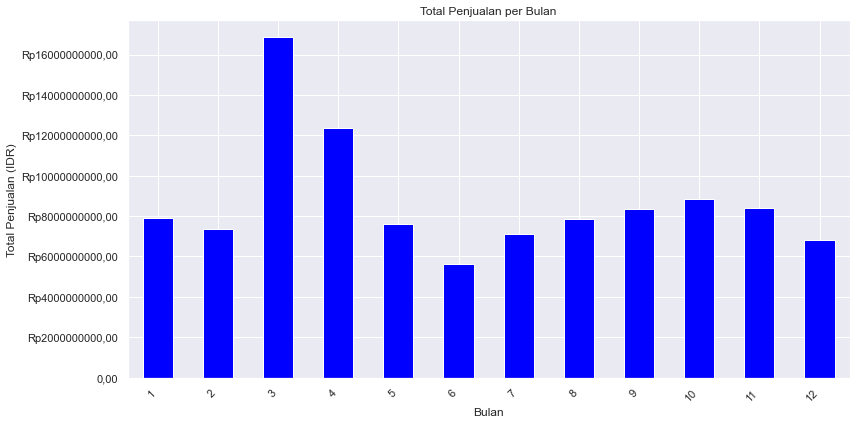

In [25]:
import locale
import matplotlib.pyplot as plt

# Setel lokal ke Indonesia untuk format mata uang rupiah
locale.setlocale(locale.LC_ALL, 'id_ID')

# Mengelompokkan berdasarkan kolom 'Bulan', kemudian menjumlahkan nilai 'SubTotal'
total_penjualan_per_bulan = df.groupby(['Bulan'])['SubTotal'].sum()

# Plotting dengan satu warna
fig, ax = plt.subplots(figsize=(12, 6))
total_penjualan_per_bulan.plot(kind='bar', color='blue')

plt.xlabel('Bulan')
plt.ylabel('Total Penjualan (IDR)')
plt.title('Total Penjualan per Bulan')
plt.xticks(rotation=45, ha='right')

# Menambahkan label untuk sumbu y dengan format mata uang rupiah
ax.yaxis.set_major_formatter(locale.currency)

plt.grid(True)
plt.tight_layout()
plt.show()

Kategori produk yang paling banyak terjual:
               Kategori    Qty
30                 KOPI  15361
40   MIE INSTANT/KERING  11590
41   MINUMAN /SOFTDRINK  11502
57                ROKOK   7515
72                 SUSU   7393


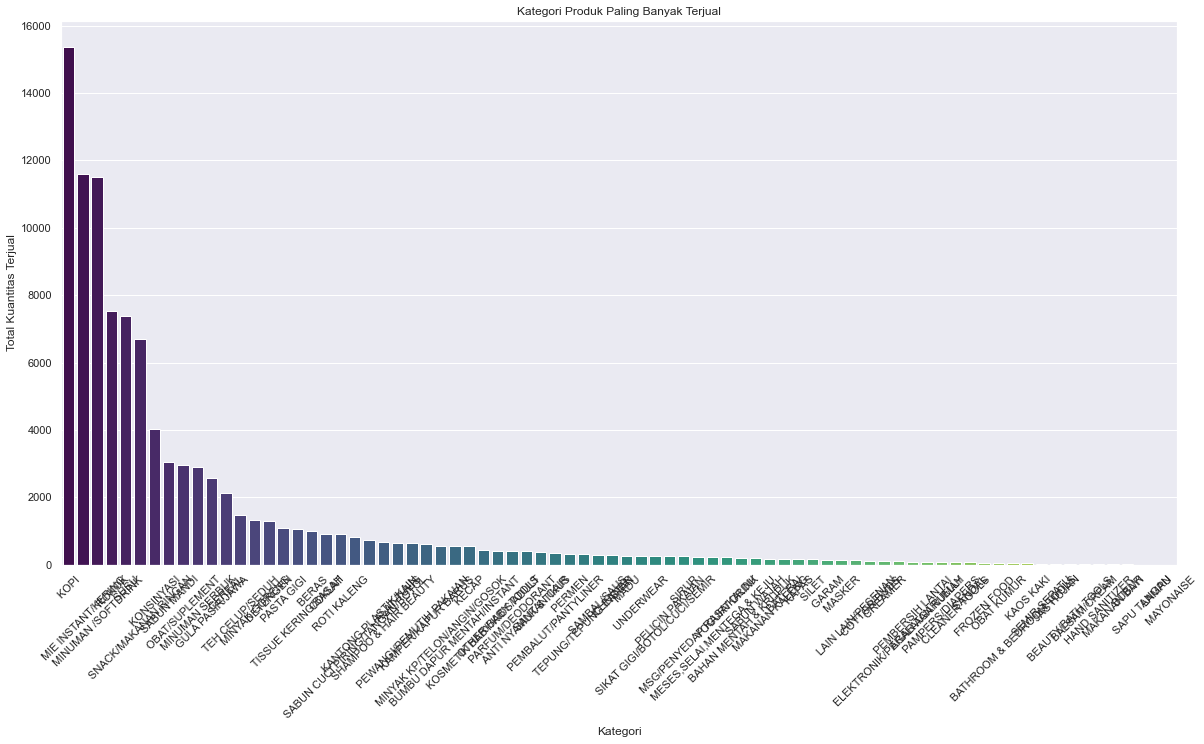

In [26]:
# Mengelompokkan data berdasarkan kategori produk dan menghitung total kuantitas penjualan untuk setiap kategori
kategori_terjual = df.groupby('Kategori')['Qty'].sum().reset_index()

# Mengurutkan kategori berdasarkan total kuantitas penjualan secara menurun
kategori_terjual = kategori_terjual.sort_values(by='Qty', ascending=False)

# Menampilkan kategori produk yang paling banyak terjual
print("Kategori produk yang paling banyak terjual:")
print(kategori_terjual.head())

# Visualisasi kategori produk yang paling banyak terjual
plt.figure(figsize=(20, 10))
sns.barplot(data=kategori_terjual, x='Kategori', y='Qty', palette='viridis')
plt.title('Kategori Produk Paling Banyak Terjual')
plt.xlabel('Kategori')
plt.ylabel('Total Kuantitas Terjual')
plt.xticks(rotation=45)
plt.show()


Produk produk yang paling banyak terjual:
                                       Produk   Qty
1435             INDOMIE GORENG SPECIAL 85 GR  3980
1757  KOPI KAPAL API SPECIAL SACHET MINI 6 GR  1640
77                           AQUA BOTOL 330ML  1596
3709               ZEE SWIZZ CHOCO MILK 40 GR  1530
1442    INDOMIE REBUS RASA AYAM SPESIAL 68 GR  1465
1402   INDOCAFE COFFEEMIX 3 IN 1 SACHET 20 GR  1396
1229                    GULA PASIR LOKAL 1 KG  1394
2117               MILO ACTIV GO SACHET 22 GR  1385
1756         KOPI KAPAL API SPECIAL MIX 24 GR  1381
1440          INDOMIE REBUS AYAM BAWANG 69 GR  1375


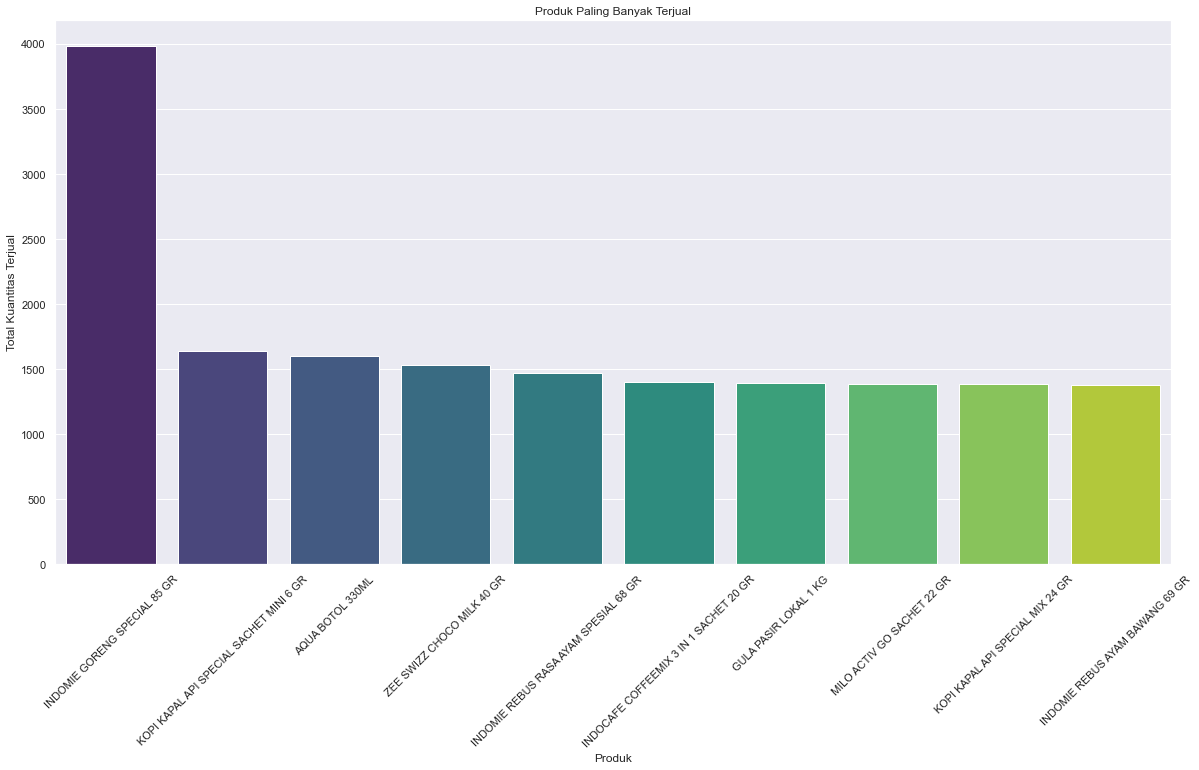

In [27]:
# Mengelompokkan data berdasarkan produk dan menghitung total kuantitas penjualan untuk setiap produk
kategori_terjual = df.groupby('Produk')['Qty'].sum().reset_index()

# Mengurutkan produk berdasarkan total kuantitas penjualan secara menurun
kategori_terjual = kategori_terjual.sort_values(by='Qty', ascending=False)

# Memilih hanya 10 produk teratas yang paling banyak terjual
top_produk_terjual = kategori_terjual.head(10)

# Menampilkan produk yang paling banyak terjual
print("Produk produk yang paling banyak terjual:")
print(top_produk_terjual)

# Visualisasi kategori produk yang paling banyak terjual
plt.figure(figsize=(20, 10))
sns.barplot(data=top_produk_terjual, x='Produk', y='Qty', palette='viridis')
plt.title('Produk Paling Banyak Terjual')
plt.xlabel('Produk')
plt.ylabel('Total Kuantitas Terjual')
plt.xticks(rotation=45)
plt.show()


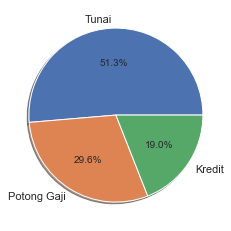

In [28]:
pie_plot("MetodePembayaran")

x_axis: Satuan
df.columns: Index(['Reference', 'Pembeli', 'Satuan', 'Produk', 'Kategori', 'Qty',
       'HargaJual', 'Diskon', 'SubTotal', 'MetodePembayaran', 'Status',
       'StatusPembayaran', 'Bulan', 'Tahun'],
      dtype='object')
df[x_axis].dtype: object


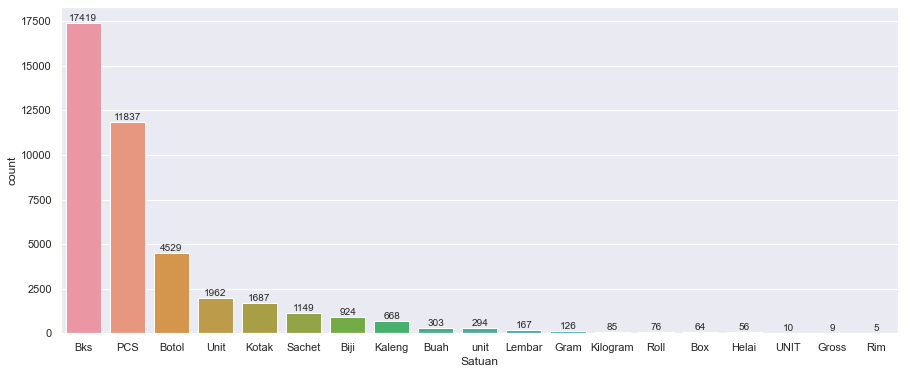

In [29]:
plt.figure(figsize = (15,6))
count_plot("Satuan") 

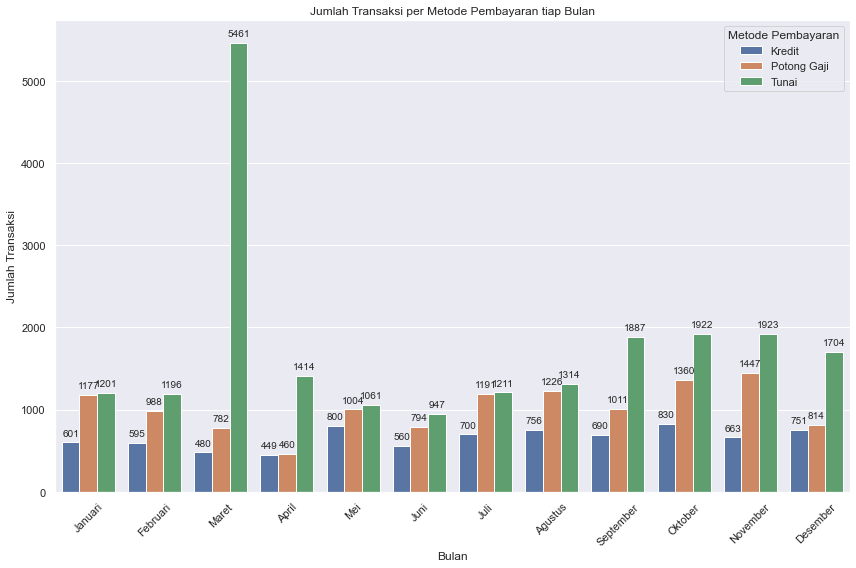

In [30]:
# Hitung jumlah transaksi metode pembayaran di setiap bulannya
transaksi_per_bulan = df.groupby(['Tahun', 'Bulan', 'MetodePembayaran']).size().reset_index(name='JumlahTransaksi')

# Ubah angka bulan menjadi nama bulan (opsional)
transaksi_per_bulan['Bulan'] = transaksi_per_bulan['Bulan'].replace({
    1: 'Januari', 2: 'Februari', 3: 'Maret', 4: 'April', 5: 'Mei', 6: 'Juni',
    7: 'Juli', 8: 'Agustus', 9: 'September', 10: 'Oktober', 11: 'November', 12: 'Desember'
})

# Visualisasi jumlah transaksi metode pembayaran di setiap bulan
plt.figure(figsize=(12, 8))
plot = sns.barplot(data=transaksi_per_bulan, x='Bulan', y='JumlahTransaksi', hue='MetodePembayaran')
plt.title('Jumlah Transaksi per Metode Pembayaran tiap Bulan')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Transaksi')
plt.xticks(rotation=45)
plt.legend(title='Metode Pembayaran')

# Menambahkan angka jumlah transaksi di atas setiap bar
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.0f'), 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', 
                  xytext = (0, 9), 
                  textcoords = 'offset points')

plt.tight_layout()
plt.show()

In [31]:
df.corr()

,Qty,HargaJual,Diskon,SubTotal,Bulan,Tahun
Qty,1.000000,-0.069068,NaN,0.309835,-0.017030,NaN
HargaJual,-0.069068,1.000000,NaN,0.363405,-0.036757,NaN
Diskon,NaN,NaN,NaN,NaN,NaN,NaN
SubTotal,0.309835,0.363405,NaN,1.000000,-0.041989,NaN
Bulan,-0.017030,-0.036757,NaN,-0.041989,1.000000,NaN
Tahun,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

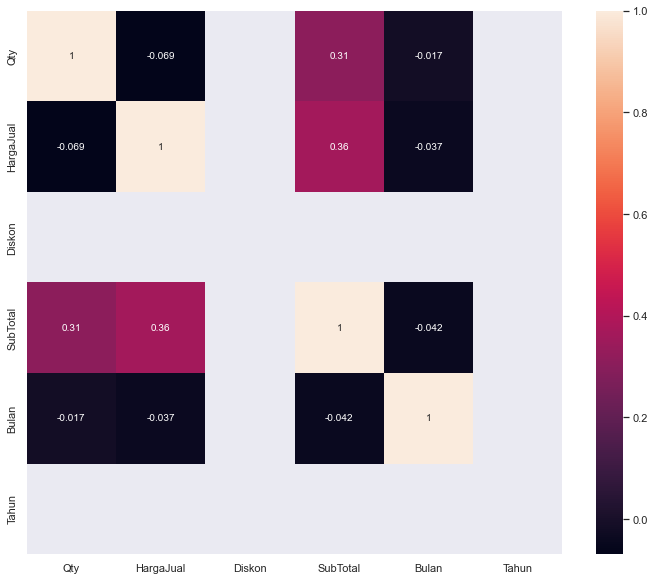

In [32]:
plt.figure(figsize = (12,10))
sns.heatmap(df.corr(), annot =True)

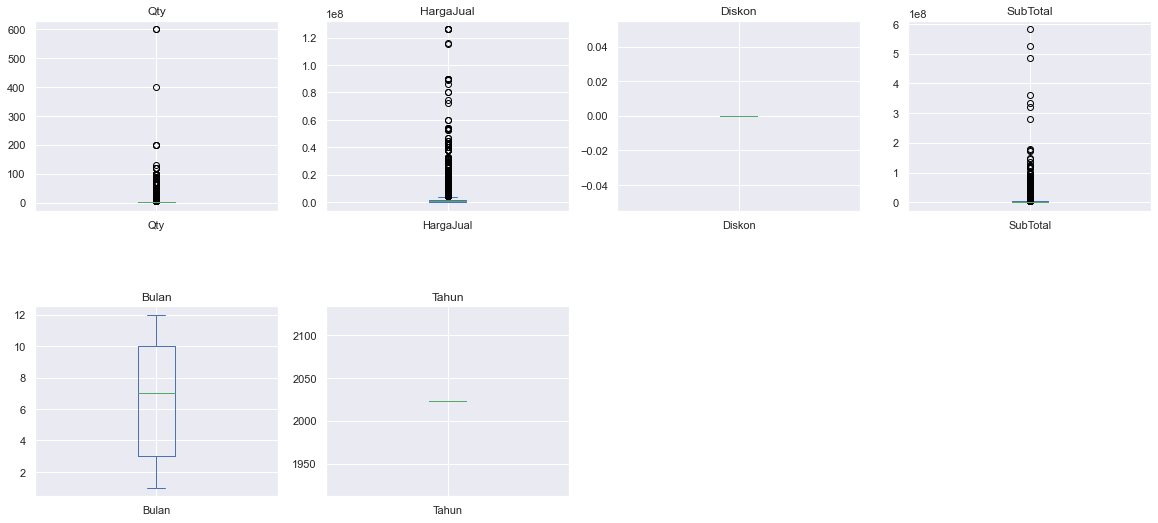

In [33]:
# Membuat gambar dengan ukuran yang sesuai
plt.figure(figsize=(20,14))

# Memeriksa tipe data kolom dan hanya memplot kolom-kolom numerik
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Menggunakan loop untuk menampilkan boxplot untuk setiap kolom numerik
for i, col in enumerate(numeric_cols):
    plt.subplot(3, 4, i + 1)  # Membuat subplot dengan urutan 3 baris dan 4 kolom
    df[col].plot(kind='box')
    plt.title(col)  # Menyertakan judul subplot dengan nama kolom

# Mengatur jarak antar subplot
plt.subplots_adjust(hspace=0.5)

# Menampilkan plot
plt.show()

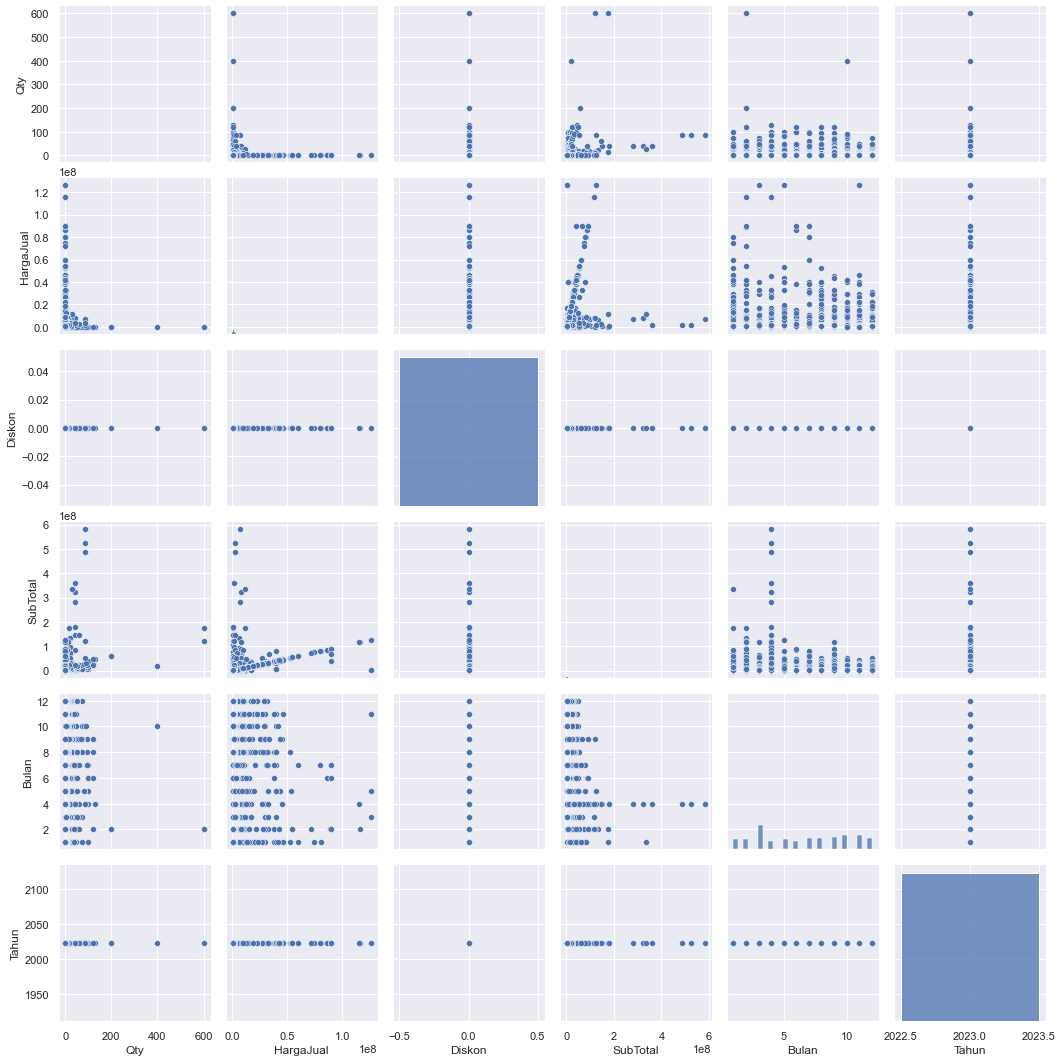

In [34]:
sns.pairplot(data=df)

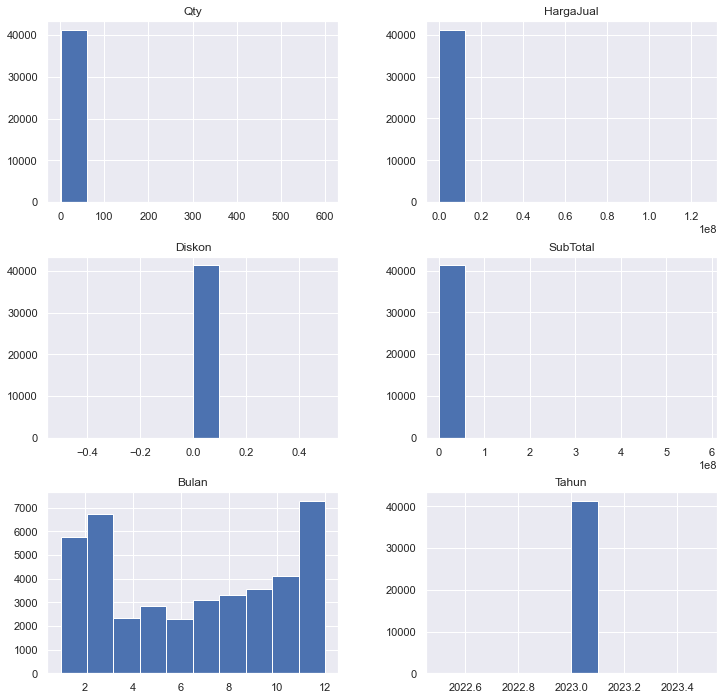

In [35]:
# Plotting Histogram for all
df.hist(figsize=(12,12))
plt.show()